In [1]:
# Cell 2 — imports + load SF driving graph
import json
import re
from collections import defaultdict

import osmnx as ox
import networkx as nx
import geopandas as gpd
from shapely.geometry import shape
import matplotlib.pyplot as plt

ox.settings.use_cache = True
ox.settings.log_console = False

place = "San Francisco, California, USA"
G = ox.graph_from_place(place, network_type="drive", simplify=True)
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)  # edge attr: "travel_time" (seconds)

len(G), G.number_of_edges()

(9997, 27556)


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


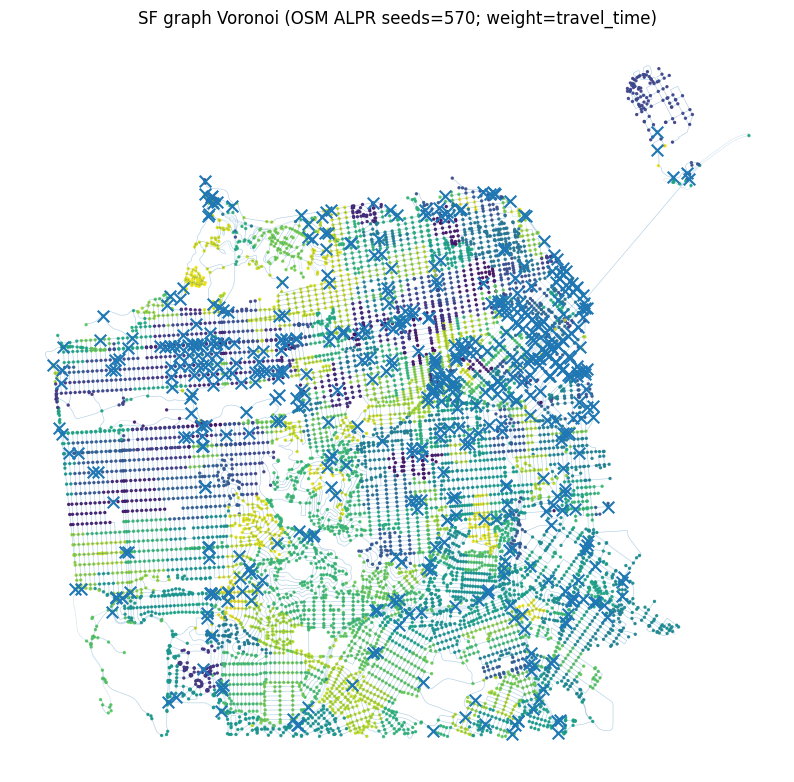

Fetched 1237 ALPR-tagged OSM features; using 570 unique seed nodes.
Objects now available: alpr_gdf, seed_df, owner, gdf_nodes, gdf_edges, G


In [3]:
# Jupyter single-cell: fetch ALPR cameras from OpenStreetMap (SF) and compute a graph Voronoi partition
# Outputs:
#   - alpr_gdf: GeoDataFrame of OSM ALPR features (nodes/ways/relations)
#   - seed_df: DataFrame mapping region_id -> osmid -> graph node
#   - owner: dict[graph_node] -> region_id
#   - gdf_nodes / gdf_edges: GeoDataFrames with owner + travel time
#   - plot of partition (nodes colored by region, ALPR seeds marked with x)

%pip -q install osmnx networkx geopandas shapely pyproj matplotlib

import osmnx as ox
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

ox.settings.use_cache = True
ox.settings.log_console = False

place = "San Francisco, California, USA"

# 1) Fetch ALPR features from OSM (common tagging scheme)
#    This returns a GeoDataFrame with an 'osmid' column and geometries (points/lines/polygons).
tags = {"man_made": "surveillance", "surveillance:type": "ALPR"}
alpr_gdf = ox.features_from_place(place, tags)

if alpr_gdf.empty:
    raise RuntimeError("No ALPR features returned from OSM for this place query.")

# 2) Build the routing graph (drive) and travel-time weights
G = ox.graph_from_place(place, network_type="drive", simplify=True)
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)  # seconds in edge attr "travel_time"

# 3) Convert ALPR geometries to seed nodes on the graph
#    - For points: use point coordinates
#    - For lines/polygons: use centroid
geoms = alpr_gdf.geometry
seed_points = geoms.apply(lambda g: g if g.geom_type == "Point" else g.centroid)

# Snap to nearest graph nodes
seed_nodes = [
    ox.distance.nearest_nodes(G, X=float(p.x), Y=float(p.y))
    for p in seed_points
]

# De-duplicate seeds (multiple OSM features can snap to the same graph node)
seen = set()
unique_seed_nodes = []
unique_idx = []
for idx, n in zip(alpr_gdf.index, seed_nodes):
    if n in seen:
        continue
    seen.add(n)
    unique_seed_nodes.append(n)
    unique_idx.append(idx)

seed_nodes = unique_seed_nodes
seed_ids = list(range(len(seed_nodes)))

# Seed metadata table
seed_df = pd.DataFrame({
    "region_id": seed_ids,
    "graph_node": seed_nodes,
    "osmid": [alpr_gdf.loc[i].get("osmid") for i in unique_idx],
    "name":  [alpr_gdf.loc[i].get("name") for i in unique_idx],
    "operator": [alpr_gdf.loc[i].get("operator") for i in unique_idx],
    "surveillance:type": [alpr_gdf.loc[i].get("surveillance:type") for i in unique_idx],
}).reset_index(drop=True)

# 4) Graph Voronoi partition via multi-source shortest paths (travel_time)
sources = {n: sid for sid, n in zip(seed_ids, seed_nodes)}

H = G.copy()
super_source = "_super_source_"
H.add_node(super_source)
for sid, sn in zip(seed_ids, seed_nodes):
    H.add_edge(super_source, sn, travel_time=0.0, length=0.0, _seed=sid)

dist, paths = nx.single_source_dijkstra(H, source=super_source, weight="travel_time")

owner = {}
for v, p in paths.items():
    if v == super_source:
        continue
    seed_in_path = next((u for u in p[1:] if u in sources), None)
    owner[v] = sources[seed_in_path] if seed_in_path is not None else None

dist.pop(super_source, None)
owner.pop(super_source, None)

# 5) Package for plotting
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G, nodes=True, edges=True)
gdf_nodes["owner"] = gdf_nodes.index.map(owner)
gdf_nodes["tt_sec"] = gdf_nodes.index.map(dist)

# 6) Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf_edges.plot(ax=ax, linewidth=0.4, alpha=0.2)
gdf_nodes.dropna(subset=["owner"]).plot(ax=ax, column="owner", markersize=2, legend=False, alpha=0.9)

seed_geom = gdf_nodes.loc[seed_nodes].geometry
ax.scatter(seed_geom.x, seed_geom.y, s=70, marker="x")

ax.set_title(f"SF graph Voronoi (OSM ALPR seeds={len(seed_nodes)}; weight=travel_time)")
ax.set_axis_off()
plt.show()

print(f"Fetched {len(alpr_gdf)} ALPR-tagged OSM features; using {len(seed_nodes)} unique seed nodes.")
print("Objects now available: alpr_gdf, seed_df, owner, gdf_nodes, gdf_edges, G")

In [2]:
# Interactive ALPR Voronoi map — fixed for current OSMnx versions

%pip -q install osmnx networkx geopandas shapely pyproj folium branca

import osmnx as ox
import networkx as nx
import pandas as pd
import geopandas as gpd
import folium
from shapely.ops import unary_union
from branca.colormap import linear

ox.settings.use_cache = True
ox.settings.log_console = False

place = "San Francisco, California, USA"

# -------------------------------
# 1) Fetch ALPR features from OSM
# -------------------------------
tags = {"man_made": "surveillance", "surveillance:type": "ALPR"}
alpr_gdf = ox.features_from_place(place, tags)

if alpr_gdf.empty:
    raise RuntimeError("No ALPR features returned from OSM.")

# Points for nodes; centroid for lines/polygons
seed_points = alpr_gdf.geometry.apply(lambda g: g if g.geom_type == "Point" else g.centroid)

# -------------------------------
# 2) Build routing graph
# -------------------------------
G = ox.graph_from_place(place, network_type="drive", simplify=True)
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# -------------------------------
# 3) Snap ALPR to graph nodes
# -------------------------------
seed_nodes_raw = [ox.distance.nearest_nodes(G, X=float(p.x), Y=float(p.y)) for p in seed_points]

# Deduplicate graph nodes
seen = set()
seed_nodes = []
seed_rows = []

for idx, n in zip(alpr_gdf.index, seed_nodes_raw):
    if n in seen:
        continue
    seen.add(n)
    row = alpr_gdf.loc[idx]
    seed_nodes.append(n)
    seed_rows.append({
        "region_id": len(seed_nodes)-1,
        "graph_node": n,
        "osmid": row.get("osmid"),
        "name": row.get("name"),
        "operator": row.get("operator"),
        "geometry": seed_points.loc[idx]
    })

seed_df = pd.DataFrame(seed_rows)

# -------------------------------
# 4) Multi-source Dijkstra (Voronoi)
# -------------------------------
sources = {n: i for i, n in enumerate(seed_nodes)}

H = G.copy()
super_source = "_super_source_"
H.add_node(super_source)

for sid, sn in enumerate(seed_nodes):
    H.add_edge(super_source, sn, travel_time=0.0)

dist, paths = nx.single_source_dijkstra(H, super_source, weight="travel_time")

owner = {}
for v, p in paths.items():
    if v == super_source:
        continue
    seed_in_path = next((u for u in p[1:] if u in sources), None)
    owner[v] = sources.get(seed_in_path)

# -------------------------------
# 5) Convert graph to GeoDataFrames
# -------------------------------
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G, nodes=True, edges=True)
gdf_nodes["owner"] = gdf_nodes.index.map(owner)

# Project to metric CRS for polygon building
gdf_nodes_proj = gdf_nodes.dropna(subset=["owner"]).to_crs(epsg=3857)

# -------------------------------
# 6) Build region hull polygons
# -------------------------------
region_polys = []
for rid, grp in gdf_nodes_proj.groupby("owner"):
    pts = grp.geometry
    if len(pts) > 1500:   # subsample for speed if large
        pts = pts.sample(1500, random_state=0)
    hull = unary_union(list(pts)).convex_hull
    if not hull.is_empty:
        region_polys.append({"region_id": int(rid), "geometry": hull})

regions_gdf = gpd.GeoDataFrame(region_polys, crs="EPSG:3857").to_crs(epsg=4326)

# -------------------------------
# 7) Build interactive Folium map
# -------------------------------
m = folium.Map(location=(37.7749, -122.4194), zoom_start=12, tiles="CartoDB positron")

cmap = linear.Set1_09.scale(0, max(1, len(seed_nodes)-1))

def style_fn(feat):
    rid = feat["properties"]["region_id"]
    return {"fillColor": cmap(rid), "color": cmap(rid), "weight": 2, "fillOpacity": 0.15}

def highlight_fn(feat):
    rid = feat["properties"]["region_id"]
    return {"fillColor": cmap(rid), "color": cmap(rid), "weight": 4, "fillOpacity": 0.3}

folium.GeoJson(
    regions_gdf,
    style_function=style_fn,
    highlight_function=highlight_fn,
    tooltip=folium.GeoJsonTooltip(fields=["region_id"], aliases=["Region:"])
).add_to(m)

# ALPR markers with hover tooltips
for r in seed_df.itertuples(index=False):
    lat, lon = float(r.geometry.y), float(r.geometry.x)
    tip = f"Region {r.region_id}<br>OSM id: {r.osmid}<br>{r.operator or ''}"
    folium.CircleMarker(
        location=(lat, lon),
        radius=5,
        weight=2,
        fill=True,
        fill_opacity=0.9,
        tooltip=tip
    ).add_to(m)

m


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
